In [1]:
!pip install -q transformers datasets scikit-learn

In [3]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------ --------------- 1.0/1.7 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.5 MB/s eta 0:00:00


In [17]:
!pip install -q transformers tensorflow_datasets scikit-learn

In [29]:
# Step 2: Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification, create_optimizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [30]:
# Step 3: Load IMDB via TensorFlow Datasets
ds = tfds.load("imdb_reviews", split=["train", "test"], as_supervised=True)
train_ds_full, test_ds_full = ds

In [31]:
# Step 4: Sample for speed (1500 for training, 500 for testing)
train_ds = train_ds_full.shuffle(25000, seed=42).take(1500)
valid_ds = train_ds_full.skip(1500).shuffle(23500, seed=42).take(500)
test_ds = test_ds_full.shuffle(25000, seed=42).take(500)

In [32]:
#  Step 5: Convert to pandas-like lists for tokenization
train_texts = []
train_labels = []
for text, label in train_ds:
    train_texts.append(text.numpy().decode('utf-8'))
    train_labels.append(int(label.numpy()))

val_texts = []
val_labels = []
for text, label in valid_ds:
    val_texts.append(text.numpy().decode('utf-8'))
    val_labels.append(int(label.numpy()))

test_texts = []
test_labels = []
for text, label in test_ds:
    test_texts.append(text.numpy().decode('utf-8'))
    test_labels.append(int(label.numpy()))

In [33]:
# Step 6: Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [34]:
# Step 7: Tokenize all splits
def tokenize_texts(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="tf")

train_enc = tokenize_texts(train_texts)
val_enc = tokenize_texts(val_texts)
test_enc = tokenize_texts(test_texts)

In [35]:

# Step 8: Create tf.data.Dataset from encoded inputs
def build_tf_dataset(enc, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((dict(enc), labels))
    if shuffle: ds = ds.shuffle(len(labels))
    return ds.batch(16).prefetch(tf.data.AUTOTUNE)

train_tf = build_tf_dataset(train_enc, train_labels, shuffle=True)
val_tf = build_tf_dataset(val_enc, val_labels)
test_tf = build_tf_dataset(test_enc, test_labels)

In [36]:
# Step 9: Load pretrained model
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [37]:
# Step 10: Compile model with optimizer & loss
steps = len(train_tf) * 2
opt, lr = create_optimizer(init_lr=2e-5, num_train_steps=steps, num_warmup_steps=0)
model.compile(optimizer=opt, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [38]:
# Step 11: Train (3 epochs for speed)
history = model.fit(train_tf, validation_data=val_tf, epochs=4)

Epoch 1/3
94/94 [==============================] - 1289s 13s/step - loss: 0.6097 - accuracy: 0.6547 - val_loss: 0.4430 - val_accuracy: 0.8080
Epoch 2/3
94/94 [==============================] - 1223s 13s/step - loss: 0.3585 - accuracy: 0.8547 - val_loss: 0.3986 - val_accuracy: 0.8200
Epoch 3/3
94/94 [==============================] - 1324s 14s/step - loss: 0.2993 - accuracy: 0.8887 - val_loss: 0.3986 - val_accuracy: 0.8200


In [39]:
# Step 12: Evaluate on test set
loss, acc = model.evaluate(test_tf)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

32/32 [==============================] - 147s 5s/step - loss: 0.4107 - accuracy: 0.8320

✅ Test Accuracy: 83.20%


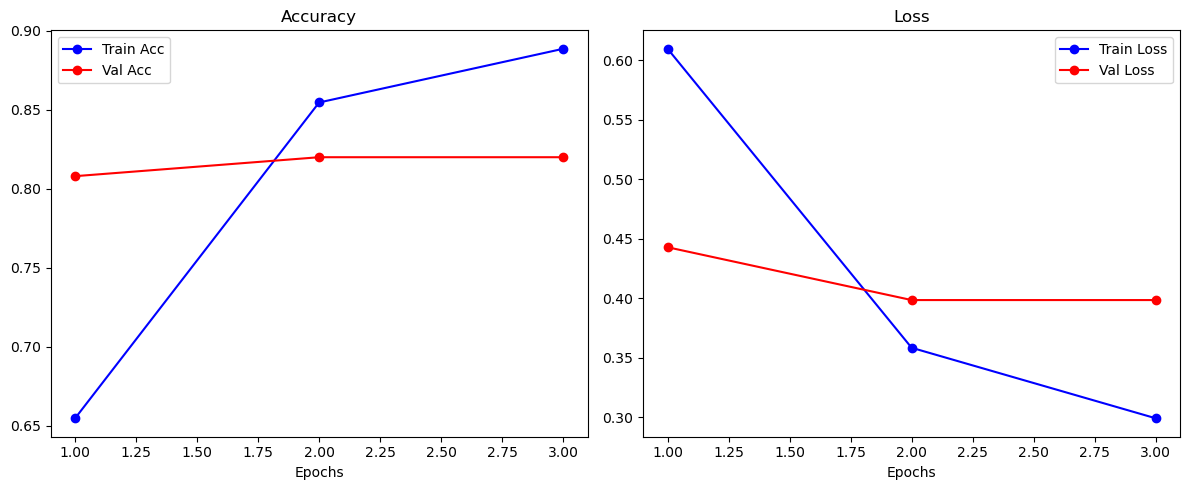

In [40]:
# Step 13: Plot training metrics
epochs = range(1, len(history.history["accuracy"]) + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], 'bo-', label="Train Acc")
plt.plot(epochs, history.history["val_accuracy"], 'ro-', label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], 'bo-', label="Train Loss")
plt.plot(epochs, history.history["val_loss"], 'ro-', label="Val Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Step 14: Confusion matrix
y_pred, y_true = [], []
for batch in test_tf:
    logits = model(batch[0], training=False).logits
    y_pred += list(tf.argmax(logits, axis=1).numpy())
    y_true += list(batch[1].numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()